In [1]:
data_dir= '/n/holylfs/LABS/wadduwage_lab/Lab/wadduwage-lab-data/Confocal/20200210_confocal-3d_Seeber-lab_h2ax-cells/63xZseriesSmall'

In [2]:
import glob
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage.filters
import torch
import shutil, os
import cv2

In [3]:
def save_imgs(sample_dirs, save_dir, filter_img_func, patch_size= 256):
    for sample_dir in sample_dirs:
        img= imread(sample_dir)
        im_max= np.max(img, axis=0)
        im_max_filt= torch.from_numpy(filter_img_func(im_max).astype('float'))

        patches= im_max_filt.reshape(im_max_filt.shape[0]//patch_size, patch_size, im_max_filt.shape[0]//patch_size, patch_size).permute(0, 2, 1, 3).flatten(end_dim= 1)
        
        for idx in range(len(patches)):
            patch= patches[idx].numpy()
            save_img_name = sample_dir.split('/')[-1][:-4]
            save_path= f'{save_dir}/{save_img_name}_{idx}.png'
            #plt.imsave(save_path , patch)
            cv2.imwrite(save_path , (255*patch).astype('uint8'))
        type_ = save_path.split('/')[-2]
        print(f'{type_} set -> saving : {save_path}')

In [4]:
def clip_thres500(img):return np.clip(img, 0, 500)/500.0

def preprocess(img):
    B= 134.28
    img_clipped = np.clip(im_max, B, 500) 
    img_norm= (img_clipped - img_clipped.min())/(img_clipped.max()- img_clipped.min())
    return img_norm

def thresholding(img, upper_limit):
    B= 134.28
    img_clipped = (im_max < upper_limit).astype('float')
    img_norm= (img_clipped - img_clipped.min())/(img_clipped.max()- img_clipped.min())
    return img_norm

In [5]:
from kornia.morphology import dilation, erosion, opening, closing



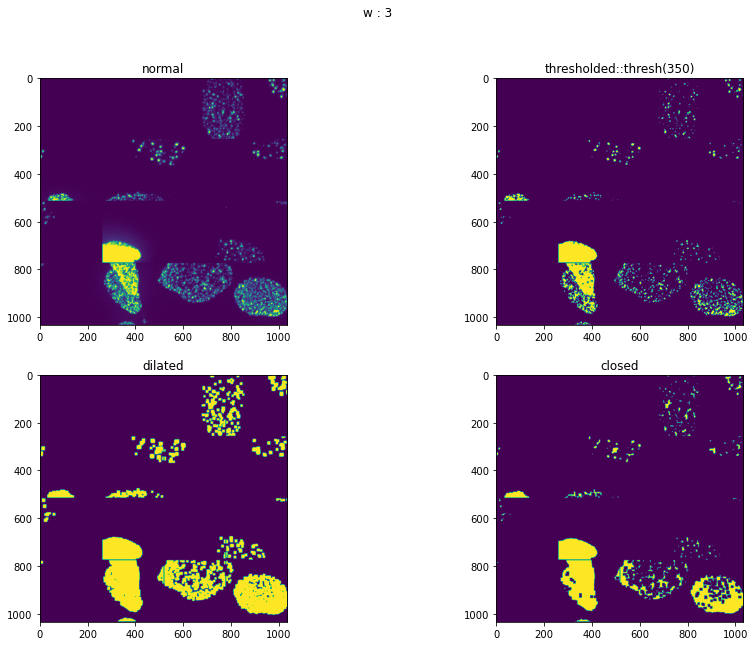

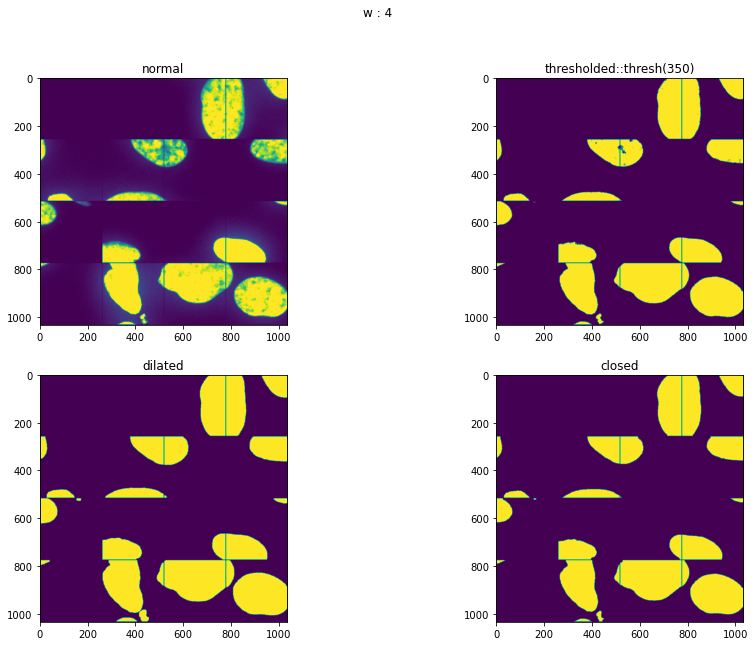

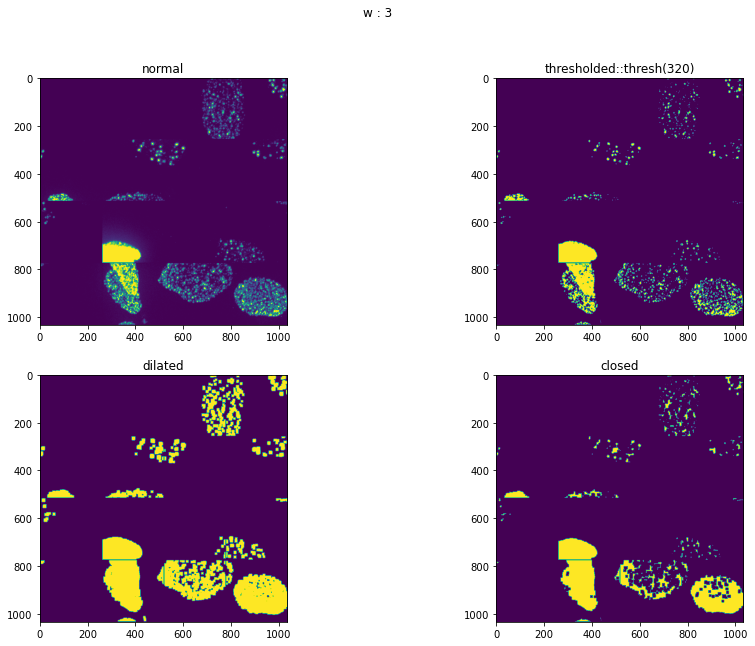

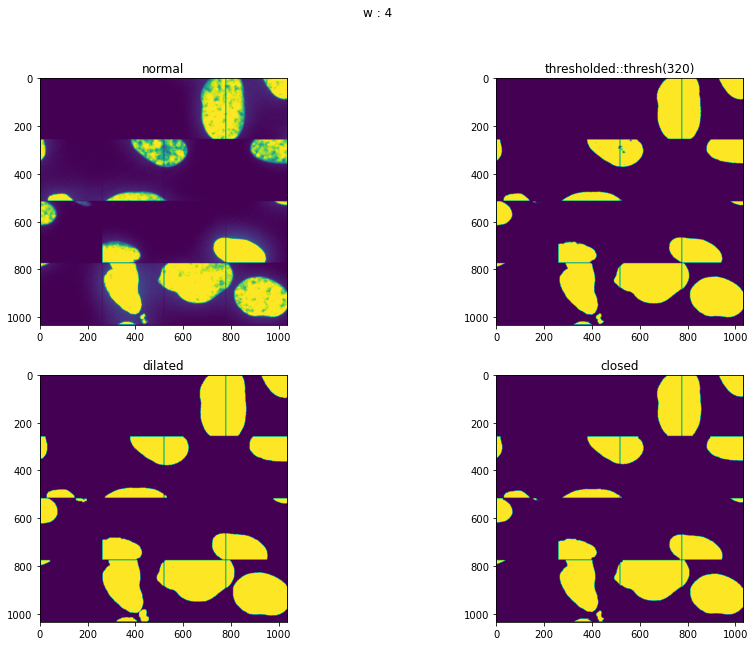

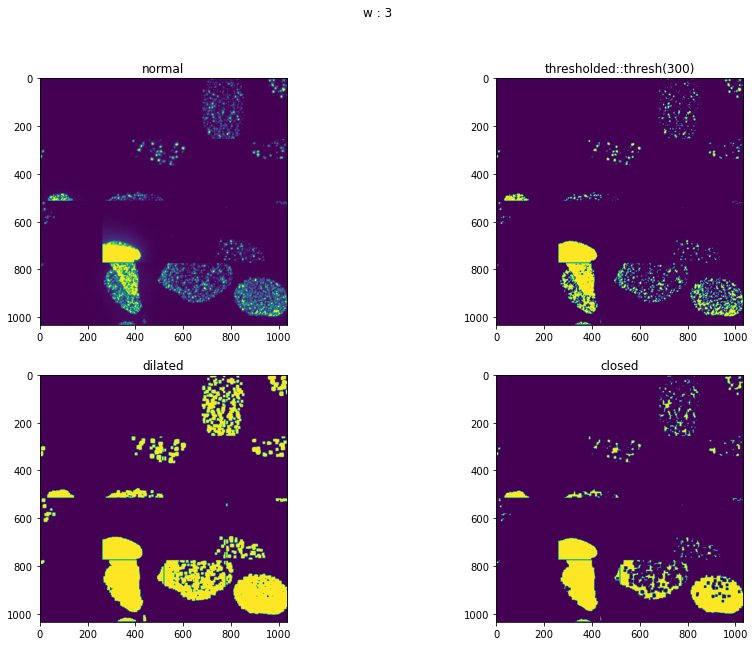

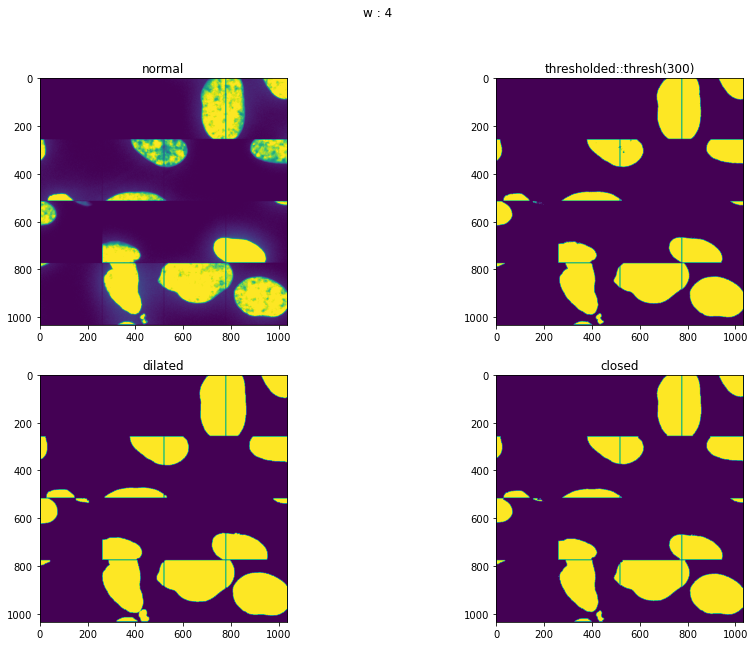

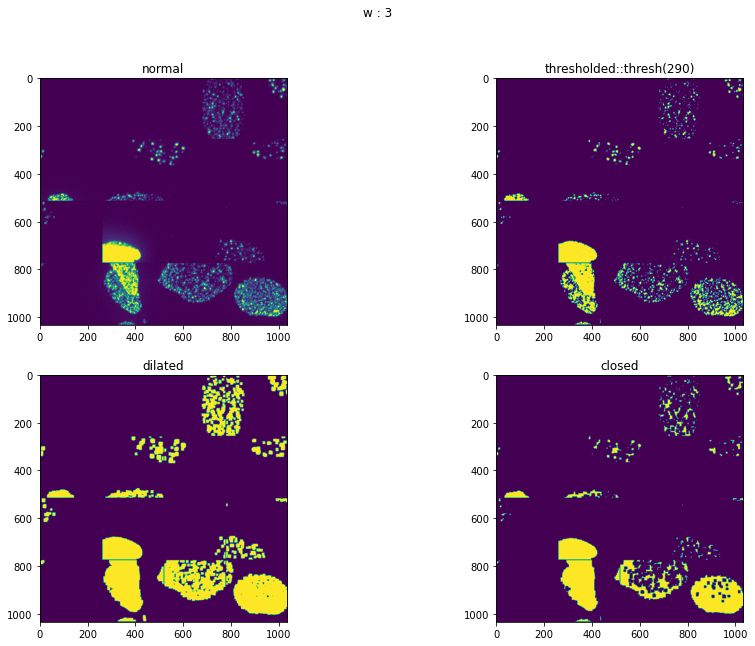

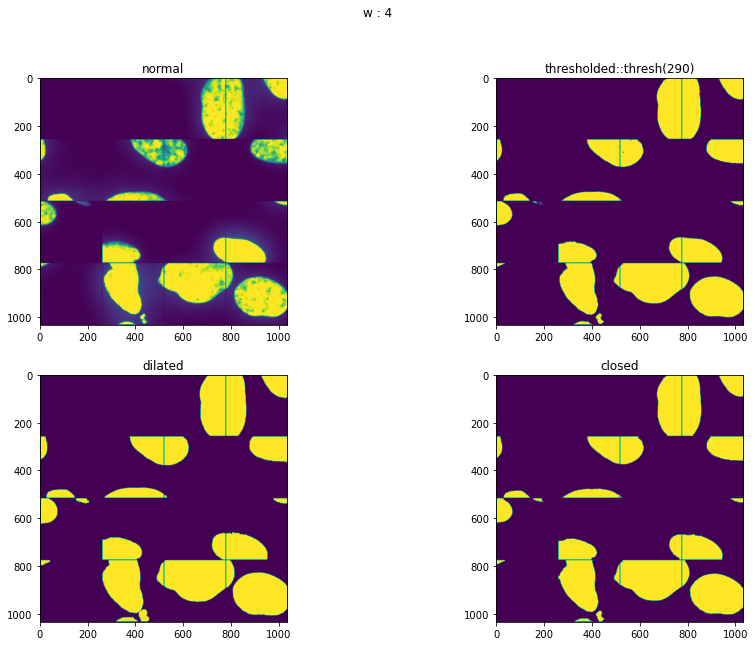

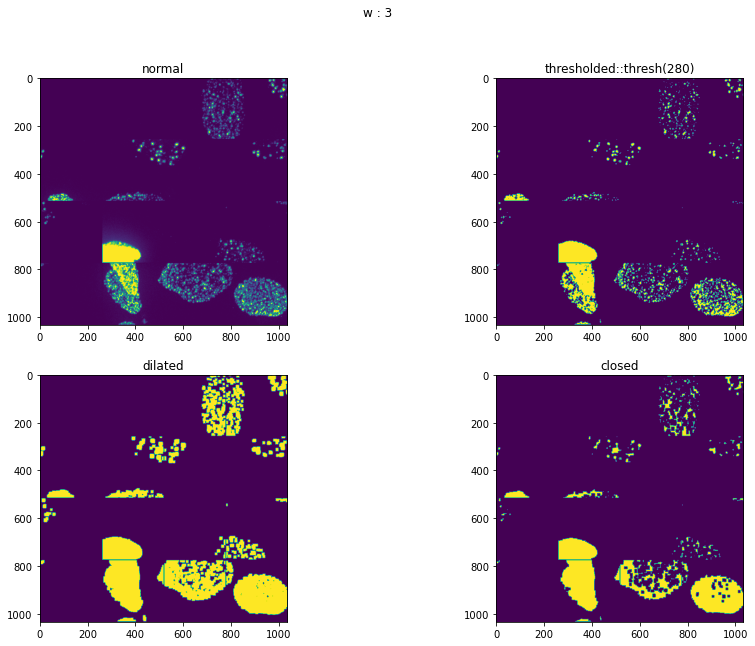

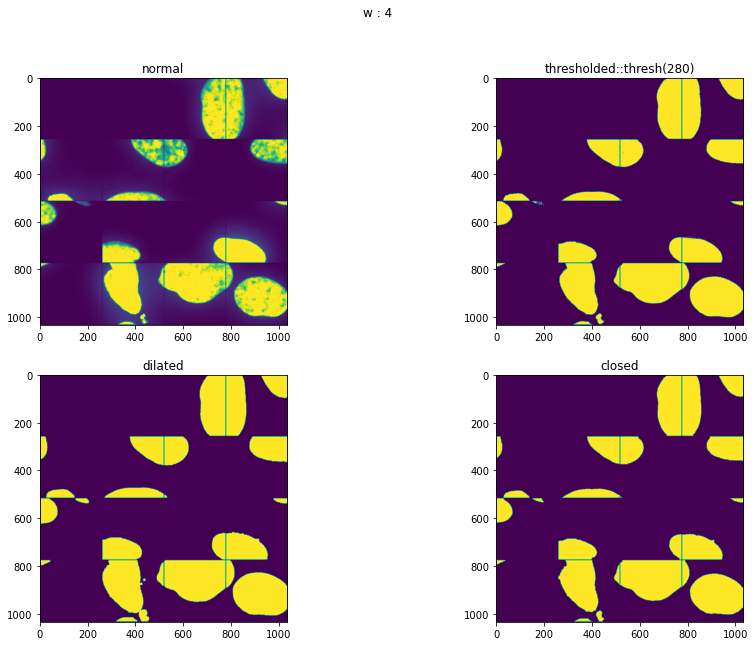

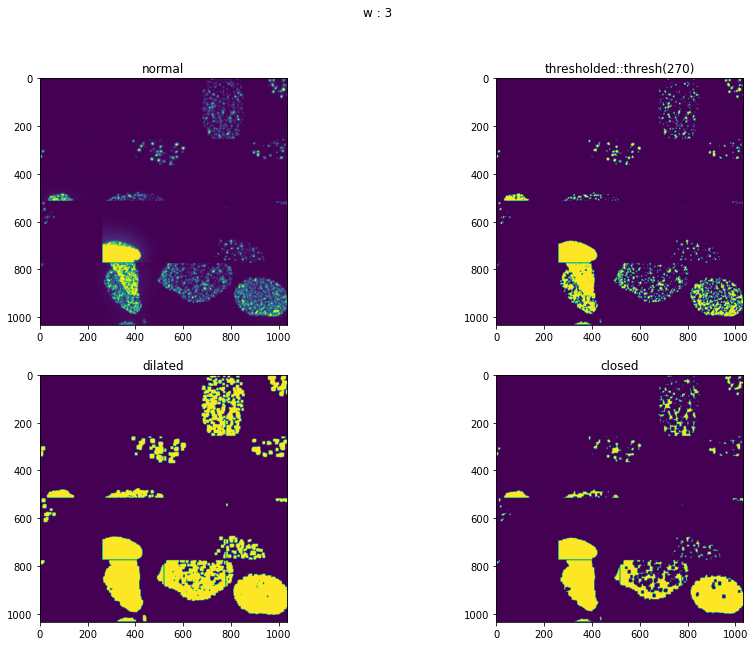

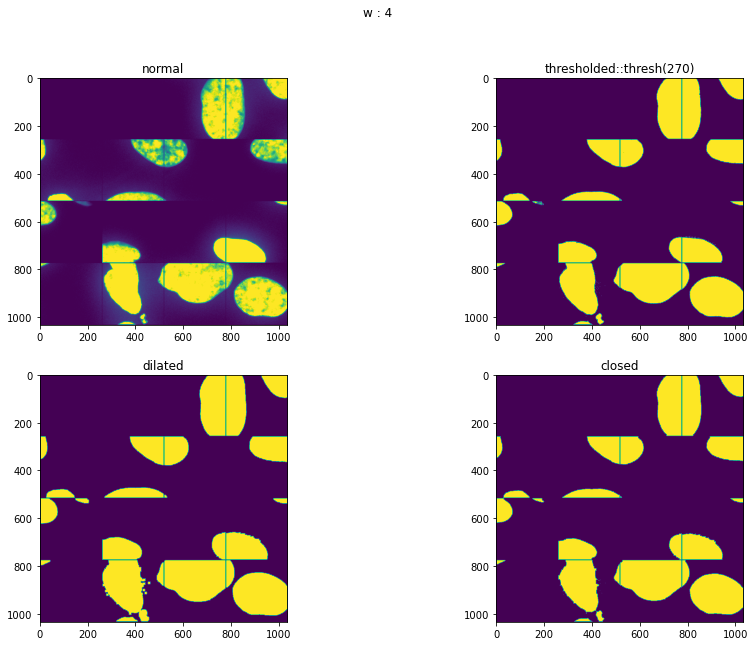

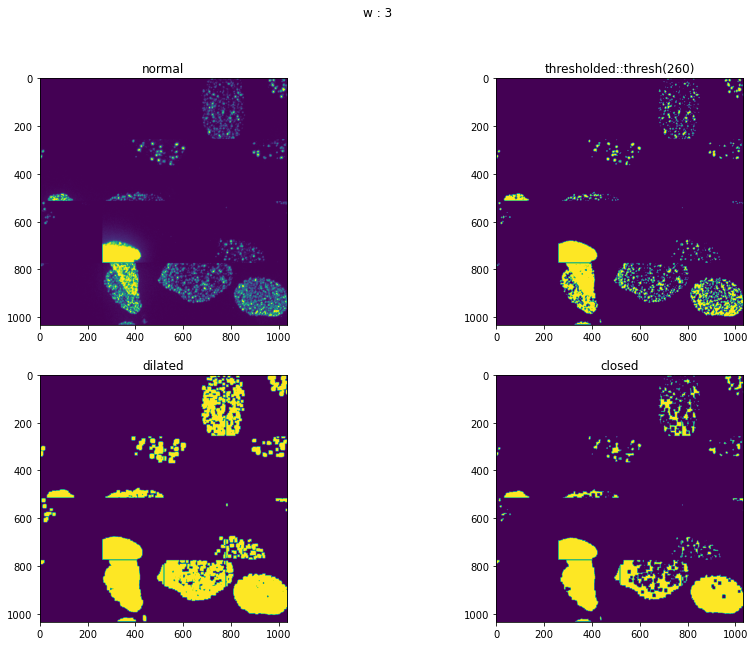

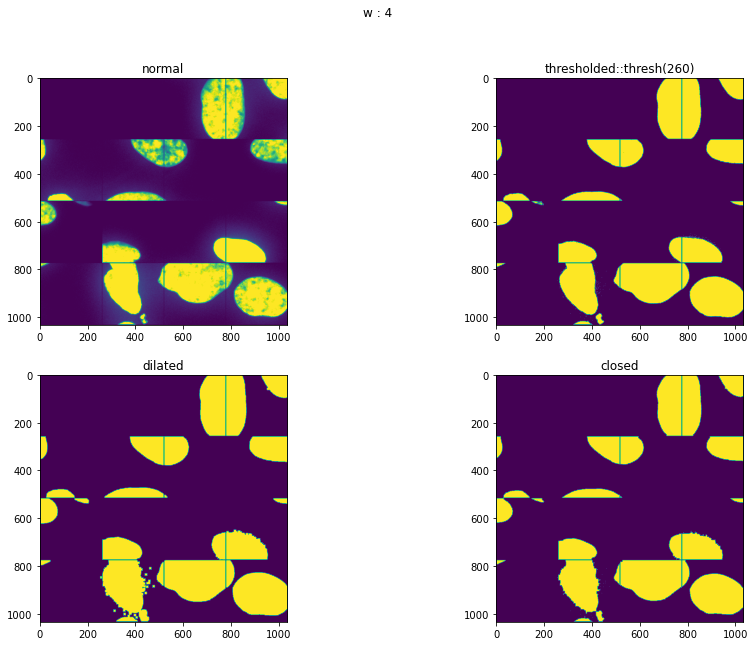

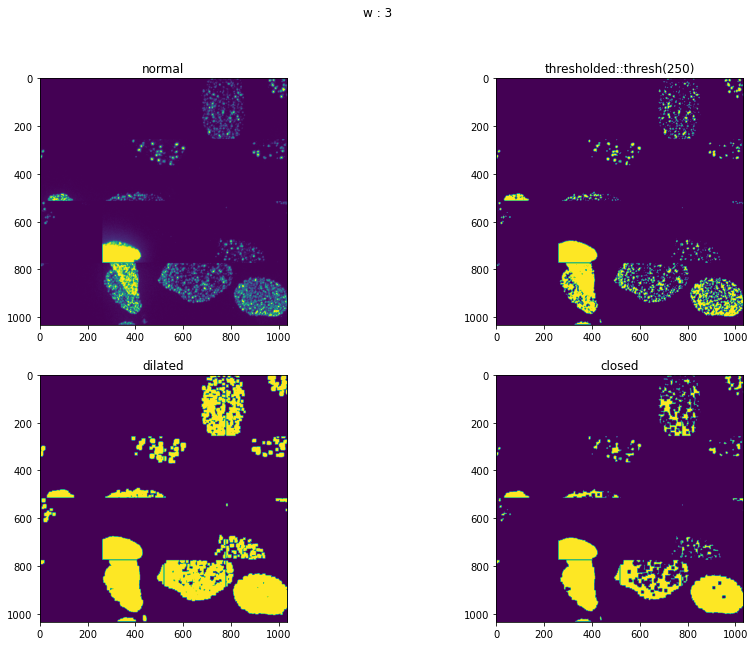

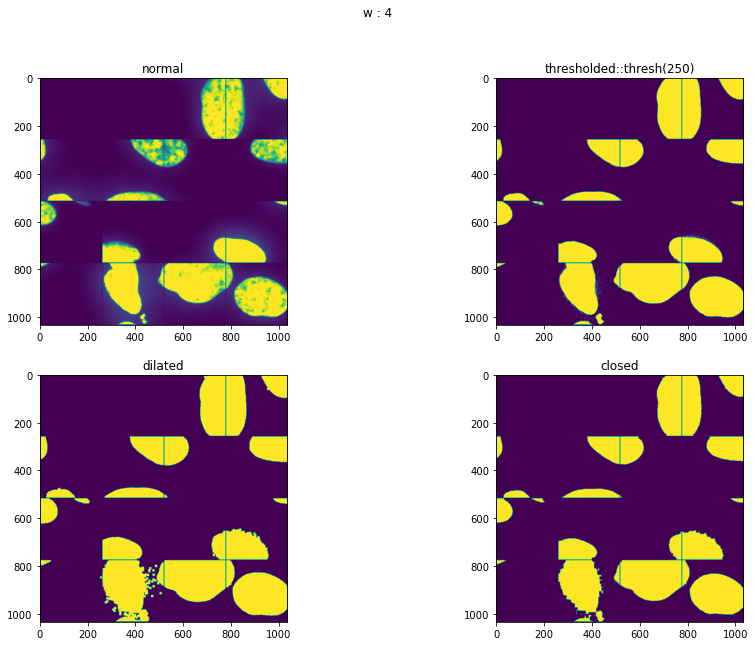

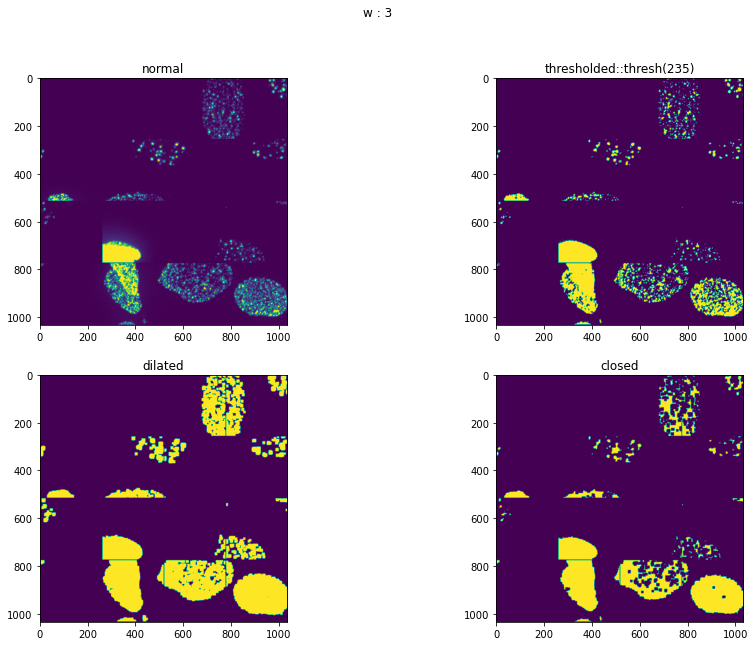

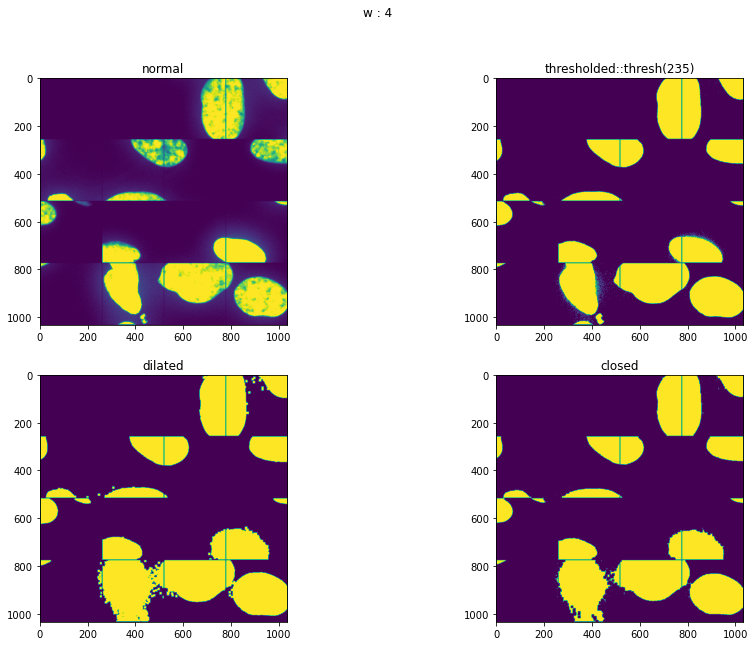

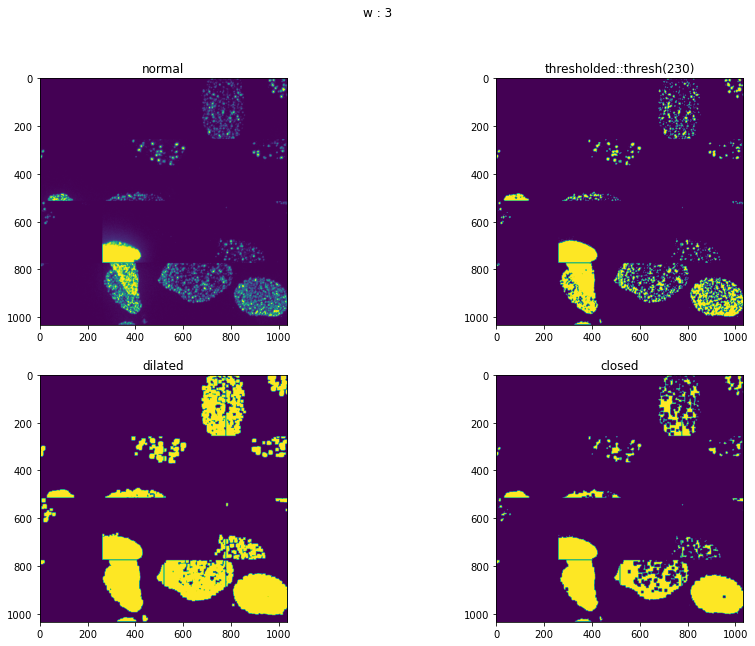

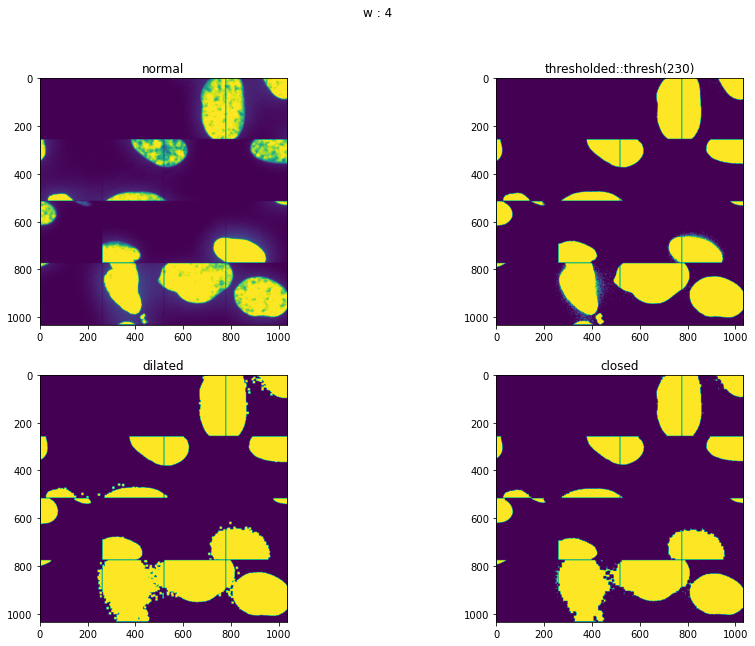

In [7]:
import cv2
import torchvision


kernel = torch.ones(10, 10)

for upper_limit in [350, 320, 300, 290, 280, 270, 260, 250, 235, 230]:
    for w_idx in [3, 4]:    
        sample_dirs =  sorted(glob.glob(f'{data_dir}/*_w{w_idx}*.stk'), key= lambda x: int(x.split('/')[-1][:-4].split('_')[-1][1:]))

        img= imread(sample_dirs[0])
        im_max= np.max(img, axis=0)
        im_max_filt= torch.from_numpy(preprocess(im_max).astype('float'))

        patch_size= 256
        
        patches= im_max_filt.reshape(im_max_filt.shape[0]//patch_size, patch_size, im_max_filt.shape[0]//patch_size, patch_size).permute(0, 2, 1, 3).flatten(end_dim= 1)
        
        thres_patches = (patches > (upper_limit- 134.28)/500.0).float()
        dilated_patches = dilation(thres_patches.unsqueeze(dim=1), kernel)[:,0]
        eroted_patches = erosion(thres_patches.unsqueeze(dim=1), kernel)[:,0]
        opened_patches = opening(thres_patches.unsqueeze(dim=1), kernel)[:,0]
        closed_patches = closing(thres_patches.unsqueeze(dim=1), kernel)[:,0]
        
        grid_img = torchvision.utils.make_grid(patches[:16].unsqueeze(1), nrow=4)
        thres_grid_img = torchvision.utils.make_grid(thres_patches[:16].unsqueeze(1), nrow=4)
        dilated_grid_img = torchvision.utils.make_grid(dilated_patches[:16].unsqueeze(1), nrow=4)
        eroted_grid_img = torchvision.utils.make_grid(eroted_patches[:16].unsqueeze(1), nrow=4)
        opened_grid_img = torchvision.utils.make_grid(opened_patches[:16].unsqueeze(1), nrow=4)
        closed_grid_img = torchvision.utils.make_grid(closed_patches[:16].unsqueeze(1), nrow=4)
        
        plt.figure(figsize= (15, 10))
        plt.subplot(2,2,1)
        plt.imshow(cv2.cvtColor((grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY))
        plt.title('normal')
        plt.subplot(2,2,2)
        plt.imshow(cv2.cvtColor((thres_grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY))
        plt.title(f'thresholded::thresh({upper_limit})')
        plt.subplot(2,2,3)
        plt.imshow(cv2.cvtColor((dilated_grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY))
        plt.title('dilated')
        plt.subplot(2,2,4)
        plt.imshow(cv2.cvtColor((closed_grid_img.permute(1,2,0).numpy()*255.0).astype('uint8'), cv2.COLOR_RGB2GRAY))
        plt.title('closed')
        
        plt.suptitle(f'w : {w_idx}')
        plt.show()